In [1]:
#x01_populationStatistics

In [2]:
import matplotlib.pyplot as plt
import uuid
import pdb
import torch
from matplotlib.animation import FuncAnimation
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import gymnasium as gym
import numpy as np
device='cpu'
from torch.utils.tensorboard import SummaryWriter



import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

from chewc.config import *
from chewc.sim import *
from chewc.callback import *
from chewc.policy import *
from chewc.lab import *

In [3]:
env = create_simulation()
env.reset()

({'population': array([[[[1, 1, 0, ..., 0, 1, 1]],
  
          [[1, 1, 0, ..., 0, 1, 1]]],
  
  
         [[[0, 1, 0, ..., 1, 0, 0]],
  
          [[0, 1, 0, ..., 1, 0, 0]]],
  
  
         [[[0, 1, 0, ..., 1, 0, 0]],
  
          [[1, 1, 0, ..., 0, 1, 1]]],
  
  
         ...,
  
  
         [[[0, 0, 1, ..., 1, 1, 1]],
  
          [[1, 1, 0, ..., 0, 1, 1]]],
  
  
         [[[0, 0, 1, ..., 1, 1, 1]],
  
          [[1, 1, 0, ..., 1, 1, 1]]],
  
  
         [[[1, 1, 0, ..., 1, 1, 1]],
  
          [[0, 0, 1, ..., 1, 1, 1]]]], dtype=int32),
  'generation': array([0.], dtype=float32)},
 {'max_phenotype': 3.315803289413452,
  'genetic_variance': 1.0000001192092896,
  'current_generation': 0})

In [4]:
# env = DummyVecEnv([lambda: env])
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CallbackList
from stable_baselines3.common.vec_env import DummyVecEnv
import random
import numpy as np

# Create your custom callbacks
genetic_variance_callback = AverageFinalGenerationCallback(log_freq=100)
action_callback = ActionTrackingCallback(log_freq=10)

# Combine the callbacks using CallbackList
combined_callbacks = CallbackList([genetic_variance_callback, action_callback])
# Wrap the environment
vec_env = DummyVecEnv([lambda: env])


# Create and train the model with the custom policy
model = PPO(CustomActorCriticPolicy, vec_env, verbose=1, tensorboard_log="./ppotb")
model.learn(total_timesteps=5000, callback=combined_callbacks)

Using cpu device
Logging to ./ppotb/PPO_5
----------------------------------
| final_generation/   |          |
|    genetic_variance | 0.204    |
|    max_phenotype    | 6.19     |
| time/               |          |
|    fps              | 304      |
|    iterations       | 1        |
|    time_elapsed     | 6        |
|    total_timesteps  | 2048     |
----------------------------------
-----------------------------------------
| final_generation/       |             |
|    genetic_variance     | 0.201       |
|    max_phenotype        | 6.18        |
| time/                   |             |
|    fps                  | 180         |
|    iterations           | 2           |
|    time_elapsed         | 22          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010097333 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.4        |
|    explained_varia

In [5]:
env

In [7]:
# Assuming you have an environment 'env' properly wrapped in a VecEnv
obs = vec_env.reset()
done = False

while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    print(scale_values(action))
    print(reward)
    # Process the observation, reward, and info as needed

tensor([[0.3474]])
[3.7016504]
tensor([[0.3591]])
[3.958506]
tensor([[0.3630]])
[4.3469067]
tensor([[0.3742]])
[5.1269383]
tensor([[0.3724]])
[5.1122704]
tensor([[0.3815]])
[5.121816]
tensor([[0.3854]])
[5.69729]
tensor([[0.3941]])
[5.7770243]
tensor([[0.3944]])
[6.0200996]
tensor([[0.4037]])
[6.2986803]


Summary Statistics:
Mean: 0.47
Median: 0.59
Standard Deviation: 1.00
Minimum: -0.63
Maximum: 3.32
Sum: 94.52


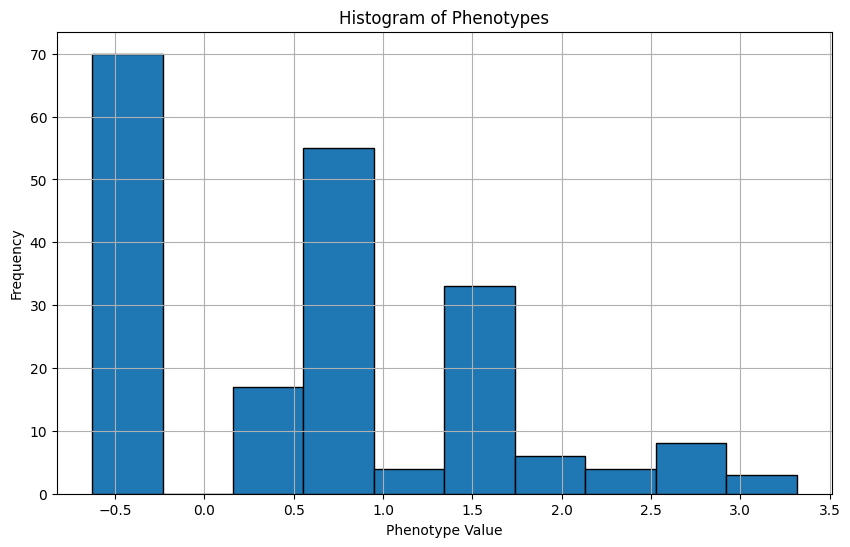

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Convert torch tensor to numpy array if necessary
phenotypes = env.population.breeding_values.numpy()

# Calculate summary statistics
mean_phenotype = np.mean(phenotypes)
median_phenotype = np.median(phenotypes)
std_phenotype = np.std(phenotypes)
min_phenotype = np.min(phenotypes)
max_phenotype = np.max(phenotypes)
sum_phenotype = np.sum(phenotypes)

# Print summary statistics
print("Summary Statistics:")
print(f"Mean: {mean_phenotype:.2f}")
print(f"Median: {median_phenotype:.2f}")
print(f"Standard Deviation: {std_phenotype:.2f}")
print(f"Minimum: {min_phenotype:.2f}")
print(f"Maximum: {max_phenotype:.2f}")
print(f"Sum: {sum_phenotype:.2f}")

# Create histogram
plt.figure(figsize=(10, 6))
plt.hist(phenotypes, bins=10, edgecolor='black')
plt.title('Histogram of Phenotypes')
plt.xlabel('Phenotype Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming SimulatedEnv and Population classes are already defined as in your code

def collect_baselines(env, actions, repetitions=100, cycles=5):
    results = {action: {'max_phenotype': [], 'gv': []} for action in actions}
    
    for action in actions:
        for _ in range(repetitions):
            env.reset()
            cycle_max_phenotype = []
            cycle_gv = []
            max_phenotype = env.population.breeding_values.max()
            gv = env.population.breeding_values.var()
            cycle_max_phenotype.append(max_phenotype)
            cycle_gv.append(gv)
            for _ in range(cycles):
                env.step(np.array(action))
                max_phenotype = env.population.breeding_values.max()
                gv = env.population.breeding_values.var()
                cycle_max_phenotype.append(max_phenotype)
                cycle_gv.append(gv)
            
            results[action]['max_phenotype'].append(cycle_max_phenotype)
            results[action]['gv'].append(cycle_gv)
    
    return results

def plot_results(results, metric):
    plt.figure(figsize=(10, 6))
    
    for action, data in results.items():
        mean_values = np.mean(data[metric], axis=0)
        std_values = np.std(data[metric], axis=0)
        cycles = range(1, len(mean_values) + 1)
        
        plt.plot(cycles, mean_values, label=f'Action {action}')
        plt.fill_between(cycles, mean_values - std_values, mean_values + std_values, alpha=0.3)
    
    plt.xlabel('Cycle')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f'{metric.replace("_", " ").title()} over Cycles')
    plt.legend()
    plt.grid(True)
    plt.show()

# Set up the environment and actions
actions = [.05, .5, .95 ]
actions = [scale_values(x, to_range=(-1, 1), from_range=(env.action_low, env.action_high)) for x in actions]
print(actions)
# Collect baselines
results = collect_baselines(env, actions, repetitions=30,cycles=env.SP.max_generations)

# Plot results
plot_results(results, 'max_phenotype')
plot_results(results, 'gv')
print(actions)

In [ ]:
env.reset()

In [ ]:

# # Create the environment
# config = {}
# env = SelectionIntensityEnvironment(SP, config)

# # Wrap the environment (required for SB3)
# env = DummyVecEnv([lambda: env])

# # Create and train the model with the custom policy
# model = PPO(CustomActorCriticPolicy, env, verbose=1, tensorboard_log="./ppotb")
# model.learn(total_timesteps=100000, callback=combined_callbacks)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# data = rewards
# # Calculate means and standard deviations
# means = [np.mean(values) for values in data.values()]
# stds = [np.std(values) for values in data.values()]

# # Create x-axis values (1 to 15)
# x = list(data.keys())

# # Create the plot
# plt.figure(figsize=(12, 6))
# plt.errorbar(x, means, yerr=stds, fmt='o-', capsize=5, capthick=2, ecolor='gray')

# # Customize the plot
# plt.title('Average Values with Standard Deviation')
# plt.xlabel('Step')
# plt.ylabel('Value')
# plt.xticks(x)  # Set x-axis ticks to match the step numbers
# plt.grid(True, linestyle='--', alpha=0.7)

# # Add a legend
# plt.legend(['Mean', 'Standard Deviation'])

# # Show the plot
# plt.tight_layout()
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# data = gvs
# # Calculate means and standard deviations
# means = [np.mean(values) for values in data.values()]
# stds = [np.std(values) for values in data.values()]

# # Create x-axis values (1 to 15)
# x = list(data.keys())

# # Create the plot
# plt.figure(figsize=(12, 6))
# plt.errorbar(x, means, yerr=stds, fmt='o-', capsize=5, capthick=2, ecolor='gray')

# # Customize the plot
# plt.title('Average Values with Standard Deviation')
# plt.xlabel('Step')
# plt.ylabel('Value')
# plt.xticks(x)  # Set x-axis ticks to match the step numbers
# plt.grid(True, linestyle='--', alpha=0.7)

# # Add a legend
# plt.legend(['Mean', 'Standard Deviation'])

# # Show the plot
# plt.tight_layout()
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# data = scaled_values
# # Calculate means and standard deviations
# means = [np.mean(values) for values in data.values()]
# stds = [np.std(values) for values in data.values()]

# # Create x-axis values (1 to 15)
# x = list(data.keys())

# # Create the plot
# plt.figure(figsize=(12, 6))
# plt.errorbar(x, means, yerr=stds, fmt='o-', capsize=5, capthick=2, ecolor='gray')

# # Customize the plot
# plt.title('Average Values with Standard Deviation')
# plt.xlabel('Step')
# plt.ylabel('Value')
# plt.xticks(x)  # Set x-axis ticks to match the step numbers
# plt.grid(True, linestyle='--', alpha=0.7)

# # Add a legend
# plt.legend(['Mean', 'Standard Deviation'])

# # Show the plot
# plt.tight_layout()
# plt.show()

In [ ]:
# rewards = {}
# scaled_values = {}
# gvs = {}

# for _ in range(3):
#     obs = env.reset()
#     done = False
#     while not done:
#         action, _states = model.predict(obs, deterministic=True)
#         obs, reward, done, info = env.step(action)

#         scaled_value = scale_values(action)
#         gen = env.buf_infos[0]['current_generation']
        
#         if gen not in rewards:
#             rewards[gen] = []
#         rewards[gen].append(float(env.buf_infos[0]['max_phenotype']))
        
#         if gen not in scaled_values:
#             scaled_values[gen] = []
#         scaled_values[gen].append(float(scaled_value))
        
#         if gen not in gvs:
#             gvs[gen] = []
#         gvs[gen].append(float(env.buf_infos[0]['genetic_variance']))        

In [ ]:
# import torch
# # Wrap the environment (required for SB3)
# # Create the environment
# config = {'sparse_reward':True}
# env = SelectionIntensityEnvironment(SP, config)
# x = env.reset()

# env = DummyVecEnv([lambda: env])

# # Create and train the model with the custom policy
# model = PPO(CustomActorCriticPolicy, env, verbose=1, tensorboard_log="./ppotb")
# model.learn(total_timesteps=50000, callback=combined_callbacks)



In [ ]:
# import torch
# # Wrap the environment (required for SB3)
# # Create the environment
# config = {'sparse_reward':False}
# env = SelectionIntensityEnvironment(SP, config)
# x = env.reset()

# env = DummyVecEnv([lambda: env])

# # Create and train the model with the custom policy
# model = PPO(CustomActorCriticPolicy, env, verbose=1, tensorboard_log="./ppotb")
# model.learn(total_timesteps=50000, callback=combined_callbacks)

# # Assuming you have an environment 'env'
# obs = env.reset()
# done = False

# while not done:
#     action, _states = model.predict(obs, deterministic=True)
#     obs, reward, done, info = env.step(action)
#     print(scale_values(action))
#     print(reward)
#     # Process the observation, reward, and info as needed